# ===========================================
# 🎬 The Movies Dataset — Analýzy (12 otázek)
# ===========================================


✅ movies_metadata načteno: (45466, 28)
✅ credits načteno: (45476, 3)
✅ keywords načteno: (46419, 2)
✅ ratings_small načteno: (100004, 4)

# Otázka 1 — Rozpočet vs Tržby
Korelace budget vs revenue: 0.740
Korelace budget vs ROI: -0.013


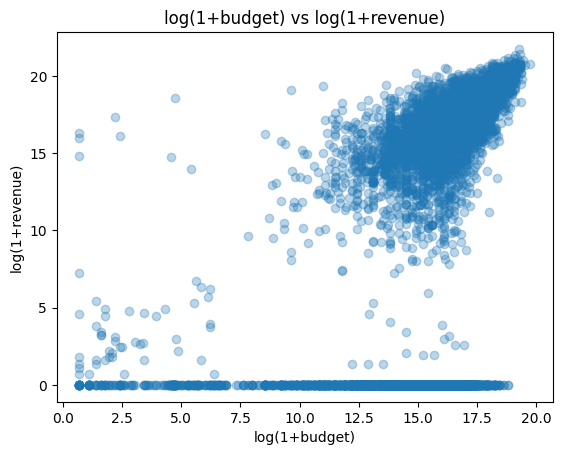


# Otázka 2 — Žánry s nadprůměrnou ROI


,n,median,mean
genres_list,,,
Family,721,1.56,"1,416.76"
Adventure,1290,1.44,794.66
Animation,428,1.35,4.63
Fantasy,734,1.14,4.15
Action,2117,0.90,484.95
Crime,1259,0.88,"9,849.50"
Romance,1493,0.88,"9,007.53"
Comedy,2790,0.85,"5,552.08"
Mystery,644,0.79,29.15



# Otázka 3 — Žánry s nejvyšším průměrným hodnocením


,n,mean,median
genres_list,,,
Animation,1934,6.28,6.50
History,1398,6.15,6.50
War,1323,6.04,6.40
Drama,20264,5.91,6.20
Music,1598,5.88,6.30
Crime,4307,5.88,6.20
Documentary,3932,5.82,6.60
Mystery,2467,5.82,6.00
Romance,6735,5.80,6.10



# Otázka 4 — Runtime vs Hodnocení
Korelace runtime vs vote_average: 0.158


/var/folders/22/q6g3m79x11l2l497x9s7fpd40000gn/T/ipykernel_49666/1106819561.py:184: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_rt = q4.groupby('runtime_bin')['vote_average'].agg(['count','mean','median']).rename(columns={'count':'n'})


,n,mean,median
runtime_bin,,,
<80,8354,5.18,6.00
80-100,20890,5.45,5.80
100-120,10950,5.99,6.20
120-140,3046,6.34,6.60
>140,1960,6.33,6.70



# Otázka 5 — Jazyk a úspěšnost


vote_average             revenue                        roi  \
                   count mean median   count          mean median count   
group                                                                     
English            32267 5.49   5.90   32267 15,171,921.56   0.00  7434   
Non-English        13193 5.93   6.30   13193  1,517,819.43   0.00  1456   

                            popularity              
                mean median      count mean median  
group                                               
English     3,463.46   0.70      32267 3.37   1.25  
Non-English 2,886.48   0.00      13193 1.83   0.93


# Otázka 6 — Země a hodnocení


,n,mean,median
countries_list,,,
Taiwan,129,6.62,6.80
Turkey,165,6.58,6.80
Indonesia,33,6.47,6.40
South Korea,495,6.47,6.60
Hong Kong,596,6.21,6.35
Portugal,128,6.20,6.50
China,372,6.20,6.40
Japan,1648,6.17,6.50
Czech Republic,209,6.16,6.60



# Otázka 7 — Režiséři a hodnocení


ValueError: You are trying to merge on object and int64 columns for key 'id'. If you wish to proceed you should use pd.concat

In [7]:
# Importy
import os, json, ast, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# Modely a interpretace pro otázku 12
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error

pd.set_option('display.max_colwidth', 120)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# -------------------------------------------
# ⚙️ PATHS a parametry
# -------------------------------------------
base_dir = Path('.')  # pokud jsou CSV vedle notebooku, ponech
PATH_MOVIES    = base_dir / 'movies_metadata.csv'
PATH_CREDITS   = base_dir / 'credits.csv'
PATH_KEYWORDS  = base_dir / 'keywords.csv'
PATH_RATINGS_S = base_dir / 'ratings_small.csv'
PATH_LINKS     = base_dir / 'links.csv'  # volitelné

MIN_FILMS_PER_GROUP = 30
RANDOM_STATE = 42

# -------------------------------------------
# Pomocné funkce
# -------------------------------------------
def exists_or_warn(path: Path, required=True):
    if not path.exists():
        msg = f'⚠️ Soubor nebyl nalezen: {path}'
        if required:
            raise FileNotFoundError(msg)
        else:
            print(msg)
            return False
    return True

def try_literal_eval(x):
    if pd.isna(x):
        return []
    if isinstance(x, (list, dict)):
        return x
    # pokus o python literal
    try:
        return ast.literal_eval(x)
    except (ValueError, SyntaxError):
        # fallback na JSON
        try:
            return json.loads(x)
        except Exception:
            return []

def parse_list_of_dicts(col, key='name'):
    return col.apply(lambda lst: [d.get(key) for d in (lst if isinstance(lst, list) else []) if isinstance(d, dict)])

def safe_to_datetime(s):
    return pd.to_datetime(s, errors='coerce')

def decade_from_year(year):
    if pd.isna(year):
        return np.nan
    try:
        y = int(year)
        return int(y // 10 * 10)
    except Exception:
        return np.nan

# -------------------------------------------
# Načtení dat + základní čištění
# -------------------------------------------
exists_or_warn(PATH_MOVIES)
movies = pd.read_csv(PATH_MOVIES, low_memory=False)

# Normalizace JSON-like sloupců
for col in ['genres', 'production_companies', 'production_countries', 'spoken_languages']:
    if col in movies.columns:
        movies[col] = movies[col].apply(try_literal_eval)

# Datum, rok, dekáda
movies['release_date'] = safe_to_datetime(movies.get('release_date'))
movies['release_year'] = movies['release_date'].dt.year
movies['decade'] = movies['release_year'].apply(decade_from_year)

# Numerické konverze
for col in ['budget','revenue','popularity','vote_average','vote_count','runtime']:
    if col in movies.columns:
        movies[col] = pd.to_numeric(movies[col], errors='coerce')

# ROI
movies['roi'] = np.where((movies['budget'] > 0) & (movies['revenue'] >= 0),
                         movies['revenue'] / movies['budget'],
                         np.nan)

# Žánry jako list
movies['genres_list'] = parse_list_of_dicts(movies['genres'], key='name')

print('✅ movies_metadata načteno:', movies.shape)

# Volitelné tabulky
if exists_or_warn(PATH_CREDITS, required=False):
    credits = pd.read_csv(PATH_CREDITS)
    credits['cast'] = credits['cast'].apply(try_literal_eval)
    credits['crew'] = credits['crew'].apply(try_literal_eval)
    print('✅ credits načteno:', credits.shape)
else:
    credits = None

if exists_or_warn(PATH_KEYWORDS, required=False):
    keywords = pd.read_csv(PATH_KEYWORDS)
    keywords['keywords'] = keywords['keywords'].apply(try_literal_eval)
    print('✅ keywords načteno:', keywords.shape)
else:
    keywords = None

if exists_or_warn(PATH_RATINGS_S, required=False):
    ratings_s = pd.read_csv(PATH_RATINGS_S)
    print('✅ ratings_small načteno:', ratings_s.shape)
else:
    ratings_s = None

# ===========================================================
# OTÁZKA 1 — Jak silně souvisí rozpočet s tržbami?
# ===========================================================
print('\n# Otázka 1 — Rozpočet vs Tržby')
q1 = movies[['budget','revenue','roi']].dropna()
q1 = q1[(q1['budget'] > 0) & (q1['revenue'] >= 0)]
corr_budget_revenue = q1['budget'].corr(q1['revenue'])
corr_budget_roi = q1['budget'].corr(q1['roi'])
print(f'Korelace budget vs revenue: {corr_budget_revenue:,.3f}')
print(f'Korelace budget vs ROI: {corr_budget_roi:,.3f}')

plt.figure()
plt.scatter(np.log1p(q1['budget']), np.log1p(q1['revenue']), alpha=0.3)
plt.title('log(1+budget) vs log(1+revenue)')
plt.xlabel('log(1+budget)')
plt.ylabel('log(1+revenue)')
plt.show()

# ===========================================================
# OTÁZKA 2 — Které žánry mají nadprůměrnou ROI?
# ===========================================================
print('\n# Otázka 2 — Žánry s nadprůměrnou ROI')
m_exp = movies.explode('genres_list')
g = m_exp.dropna(subset=['genres_list','roi'])
g = g[g['budget'] > 0]
roi_by_genre = (g.groupby('genres_list')['roi']
                  .agg(['count','median','mean'])
                  .rename(columns={'count':'n'})
                  .sort_values('median', ascending=False))
roi_by_genre = roi_by_genre[roi_by_genre['n'] >= MIN_FILMS_PER_GROUP]
display(roi_by_genre.head(15))

# ===========================================================
# OTÁZKA 3 — Které žánry mají nejvyšší průměrné hodnocení?
# ===========================================================
print('\n# Otázka 3 — Žánry s nejvyšším průměrným hodnocením')
va_by_genre = (m_exp.dropna(subset=['genres_list','vote_average'])
                 .groupby('genres_list')['vote_average']
                 .agg(['count','mean','median'])
                 .rename(columns={'count':'n'})
                 .sort_values('mean', ascending=False))
va_by_genre = va_by_genre[va_by_genre['n'] >= MIN_FILMS_PER_GROUP]
display(va_by_genre.head(15))

# ===========================================================
# OTÁZKA 4 — Získávají delší filmy vyšší hodnocení?
# ===========================================================
print('\n# Otázka 4 — Runtime vs Hodnocení')
q4 = movies[['runtime','vote_average']].dropna()
corr_rt_va = q4['runtime'].corr(q4['vote_average'])
print(f'Korelace runtime vs vote_average: {corr_rt_va:,.3f}')

bins = [0, 80, 100, 120, 140, 1000]
labels = ['<80','80-100','100-120','120-140','>140']
q4['runtime_bin'] = pd.cut(q4['runtime'], bins=bins, labels=labels, include_lowest=True)
summary_rt = q4.groupby('runtime_bin')['vote_average'].agg(['count','mean','median']).rename(columns={'count':'n'})
display(summary_rt)

# ===========================================================
# OTÁZKA 5 — Liší se úspěšnost podle jazyka? (en vs ostatní)
# ===========================================================
print('\n# Otázka 5 — Jazyk a úspěšnost')
movies['is_english'] = (movies['original_language'] == 'en').astype(int)
lang_comp = (movies
             .assign(group = np.where(movies['original_language']=='en','English','Non-English'))
             .groupby('group')[['vote_average','revenue','roi','popularity']]
             .agg(['count','mean','median']))
display(lang_comp)

# ===========================================================
# OTÁZKA 6 — Které země mají systematicky vysoké hodnocení?
# ===========================================================
print('\n# Otázka 6 — Země a hodnocení')
movies['countries_list'] = parse_list_of_dicts(movies['production_countries'], key='name')
c_exp = movies.explode('countries_list').dropna(subset=['countries_list'])
country_scores = (c_exp.groupby('countries_list')['vote_average']
                  .agg(['count','mean','median'])
                  .rename(columns={'count':'n'})
                  .sort_values('mean', ascending=False))
country_scores = country_scores[country_scores['n'] >= MIN_FILMS_PER_GROUP]
display(country_scores.head(20))

# ===========================================================
# OTÁZKA 7 — Režiséři s vyšším prům. hodnocením?
# ===========================================================
print('\n# Otázka 7 — Režiséři a hodnocení')
if credits is None:
    print('credits.csv není k dispozici — přeskočeno.')
else:
    def get_directors(crew_list):
        return [m.get('name') for m in crew_list if isinstance(m, dict) and m.get('job') == 'Director']
    tmp = credits[['id','crew']].copy()
    tmp['directors'] = tmp['crew'].apply(get_directors)
    tmp = tmp.explode('directors').dropna(subset=['directors'])
    df = movies.merge(tmp[['id','directors']], on='id', how='left')
    by_dir = (df.dropna(subset=['directors','vote_average'])
                .groupby('directors')['vote_average']
                .agg(['count','mean','median'])
                .rename(columns={'count':'n'})
                .sort_values('mean', ascending=False))
    by_dir = by_dir[by_dir['n'] >= 5]
    display(by_dir.head(20))

# ===========================================================
# OTÁZKA 8 — Herecké dvojice v komerčně úspěšných filmech
# ===========================================================
print('\n# Otázka 8 — Páry herců u hitů')
if credits is None:
    print('credits.csv není k dispozici — přeskočeno.')
else:
    from itertools import combinations
    TOP_N = 5
    def top_n_cast(lst, n=TOP_N):
        if not isinstance(lst, list):
            return []
        lst2 = sorted([x for x in lst if isinstance(x, dict) and 'name' in x and 'order' in x], key=lambda x: x['order'])
        return [x['name'] for x in lst2[:n]]
    cast_top = credits[['id','cast']].copy()
    cast_top['top_cast'] = cast_top['cast'].apply(top_n_cast)
    df = movies.merge(cast_top[['id','top_cast']], on='id', how='left').dropna(subset=['top_cast'])
    rev_q = df['revenue'].quantile(0.75)
    df_success = df[df['revenue'] >= rev_q]

    rows = []
    for _, row in df_success.iterrows():
        cast_list = row['top_cast']
        for a,b in combinations(sorted(set(cast_list)), 2):
            rows.append((a,b))
    pairs = pd.DataFrame(rows, columns=['actor_a','actor_b'])
    pair_counts = pairs.value_counts().reset_index(name='count').sort_values('count', ascending=False)
    display(pair_counts.head(20))

# ===========================================================
# OTÁZKA 9 — Jak se mění hodnocení v čase (dekády)?
# ===========================================================
print('\n# Otázka 9 — Hodnocení podle dekád')
by_decade = (movies.dropna(subset=['decade','vote_average'])
             .groupby('decade')['vote_average']
             .agg(['count','mean','median'])
             .rename(columns={'count':'n'})
             .sort_index())
display(by_decade)

plt.figure()
plt.plot(by_decade.index.astype(int), by_decade['mean'])
plt.title('Průměrné hodnocení podle dekády')
plt.xlabel('Dekáda')
plt.ylabel('Průměrné hodnocení')
plt.show()

# ===========================================================
# OTÁZKA 10 — Které žánry posílily po roce 2000?
# ===========================================================
print('\n# Otázka 10 — Žánry a změna podílu po roce 2000')
m_exp2 = movies.explode('genres_list').dropna(subset=['genres_list','release_year'])
m_exp2['period'] = np.where(m_exp2['release_year'] >= 2000, '2000+', '<2000')
genre_period = (m_exp2.groupby(['genres_list','period'])
                .size()
                .reset_index(name='n'))
totals = genre_period.groupby('period')['n'].transform('sum')
genre_period['share'] = genre_period['n'] / totals
pivot = genre_period.pivot_table(index='genres_list', columns='period', values='share', fill_value=0)
pivot['delta_share_2000plus'] = pivot.get('2000+', 0) - pivot.get('<2000', 0)
display(pivot.sort_values('delta_share_2000plus', ascending=False).head(20))

# ===========================================================
# OTÁZKA 11 — Vztah popularity a hodnocení?
# ===========================================================
print('\n# Otázka 11 — Popularita vs Hodnocení')
q11 = movies[['popularity','vote_average']].dropna()
corr_pop_rating = q11['popularity'].corr(q11['vote_average'])
print(f'Korelace popularity a hodnocení: {corr_pop_rating:,.3f}')

plt.figure()
plt.scatter(q11['popularity'], q11['vote_average'], alpha=0.3)
plt.title('Popularita vs Hodnocení')
plt.xlabel('Popularita')
plt.ylabel('Hodnocení (vote_average)')
plt.show()

# ===========================================================
# OTÁZKA 12 — Predikce popularity (Decision Tree) + interpretace
# ===========================================================
print('\n# Otázka 12 — Predikce popularity stromem (interpretovatelně)')
df = movies.copy()
df['main_genre'] = df['genres_list'].apply(lambda x: x[0] if isinstance(x, list) and len(x)>0 else np.nan)

features = ['budget','runtime','vote_average','vote_count','release_year','main_genre']
df_model = df[features + ['popularity']].dropna()

X = df_model[features]
y = df_model['popularity']

cat_cols = ['main_genre']
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer([
    ('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

model = DecisionTreeRegressor(max_depth=4, random_state=RANDOM_STATE)
pipe = Pipeline(steps=[('prep', preprocess), ('model', model)])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
print('R2:', round(r2_score(y_test, y_pred), 3))
print('MAE:', round(mean_absolute_error(y_test, y_pred), 3))

# Feature importances (post-interpretace)
ohe = pipe.named_steps['prep'].named_transformers_['cat']
ohe_feature_names = list(ohe.get_feature_names_out(cat_cols)) if hasattr(ohe, 'get_feature_names_out') else []
feature_names = num_cols + ohe_feature_names
importances = pipe.named_steps['model'].feature_importances_
imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
imp = imp[imp['importance'] > 0].sort_values('importance', ascending=False)
display(imp.head(20))

In [ ]:
import pandas as pd
import re, io, contextlib

def interpretace_aad(aad_float):
    # jednoduchá slovní interpretace podle AAD
    if aad_float >= 0.50: 
        return "výrazně nadprůměrné hodnocení"
    if aad_float >= 0.40: 
        return "velmi dobře hodnocené"
    if aad_float >= 0.30: 
        return "mírně nadprůměrné"
    return "—"

def extract_rules_df_from_attr(clm):
    """Zkusí vytáhnout tabulku pravidel přímo z atributu clm."""
    for cand in ["rulelist", "rules", "RULELIST"]:
        if hasattr(clm, cand):
            df = pd.DataFrame(getattr(clm, cand))
            if df.empty:
                return None
            # normalize názvy sloupců bez ohledu na velikost písmen
            lower_map = {c: c.lower() for c in df.columns}
            df.columns = [lower_map.get(c, c).lower() for c in df.columns]
            # očekávané klíče: rule/conf/aad
            keep = [c for c in ["rule","conf","aad","base"] if c in df.columns]
            if not keep:
                return None
            df = df[keep].copy()
            # z RULE vyextrahuj žánr, pokud je ve tvaru "genres_list(X) => Rating_cat(High)"
            if "rule" in df.columns:
                df["Žánr"] = df["rule"].str.extract(r"genres_list\(([^)]+)\)")
            if "conf" in df.columns:
                df["CONF"] = pd.to_numeric(df["conf"], errors="coerce")
            if "aad" in df.columns:
                # AAD může být ve formátu "+0.638" => necháme string + výpočet float
                df["AAD_str"] = df["aad"].astype(str)
                df["AAD_float"] = pd.to_numeric(df["aad"].astype(str).str.replace("+","", regex=False), errors="coerce")
            # sestav výsledný přehled
            out_cols = []
            if "Žánr" in df.columns: out_cols.append("Žánr")
            if "CONF" in df.columns: out_cols.append("CONF")
            if "AAD_str" in df.columns: out_cols.append("AAD_str")
            res = df[out_cols].rename(columns={"AAD_str":"AAD"}).copy()
            if "AAD_float" in df.columns:
                res["Význam"] = df["AAD_float"].apply(interpretace_aad)
            return res.dropna(subset=["Žánr","CONF"])
    return None

def extract_rules_df_from_text(clm):
    """Fallback: zachytí text print_rulelist a naparsuje řádky na DF (Žánr, CONF, AAD, Význam)."""
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        clm.print_rulelist()
    txt = buf.getvalue()

    rows = []
    # Hledáme řádky ve formátu:
    # RULEID BASE CONF AAD  genres_list(XYZ) => Rating_cat(High)
    # Např.: "1   912 0.472 +0.495 genres_list(Animation) => Rating_cat(High) | ---"
    pat = re.compile(
        r"^\s*\d+\s+\d+\s+([0-9]*\.?[0-9]+)\s+([+\-]?[0-9]*\.?[0-9]+)\s+genres_list\(([^)]+)\)\s*=>\s*Rating_cat\(High\)",
        re.MULTILINE
    )
    for m in pat.finditer(txt):
        conf = float(m.group(1))
        aad_str = m.group(2)
        genre = m.group(3)
        try:
            aad_val = float(aad_str.replace("+",""))
        except:
            aad_val = float("nan")
        rows.append({"Žánr": genre, "CONF": conf, "AAD": aad_str, "Význam": interpretace_aad(aad_val)})

    return pd.DataFrame(rows)

# --- Hlavní volání: nejdřív zkus atribut, pak text ---
df_genres_summary = extract_rules_df_from_attr(clm)
if df_genres_summary is None or df_genres_summary.empty:
    df_genres_summary = extract_rules_df_from_text(clm)

# Volitelně: seřaď podle CONF (sestupně) a vyfiltruj jen unikátní žánr⇒High
df_genres_summary = (df_genres_summary
                     .drop_duplicates(subset=["Žánr"])
                     .sort_values("CONF", ascending=False)
                     .reset_index(drop=True))

# Zobraz výsledek
df_genres_summary